<a href="https://colab.research.google.com/github/enxo7899/INM705-Deep-Learning-for-Image-Analysis/blob/main/INM705_Deep_Learning_for_Image_Analysis_EM_ML.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [30]:
!apt update -qq;
!wget https://developer.nvidia.com/compute/cuda/10.1/Prod/local_installers/cuda-repo-ubuntu1804-10-1-local-10.1.105-418.39_1.0-1_amd64.deb;
!dpkg -i cuda-repo-ubuntu1804-10-1-local-10.1.105-418.39_1.0-1_amd64.deb;
!apt-key add /var/cuda-repo-<version>/7fa2af80.pub;
!apt-get update -qq;
!apt-get install cuda -y -qq;


46 packages can be upgraded. Run 'apt list --upgradable' to see them.
--2024-05-02 22:16:39--  https://developer.nvidia.com/compute/cuda/10.1/Prod/local_installers/cuda-repo-ubuntu1804-10-1-local-10.1.105-418.39_1.0-1_amd64.deb
Resolving developer.nvidia.com (developer.nvidia.com)... 152.195.19.142
Connecting to developer.nvidia.com (developer.nvidia.com)|152.195.19.142|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://developer.nvidia.com/downloads/compute/cuda/10.1/prod/local_installers/cuda-repo-ubuntu1804-10-1-local-10.1.105-418.39_1.0-1_amd64.deb [following]
--2024-05-02 22:16:39--  https://developer.nvidia.com/downloads/compute/cuda/10.1/prod/local_installers/cuda-repo-ubuntu1804-10-1-local-10.1.105-418.39_1.0-1_amd64.deb
Reusing existing connection to developer.nvidia.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://developer.download.nvidia.com/compute/cuda/10.1/secure/Prod/local_installers/cuda-repo-ubuntu1804-10

In [31]:
pip install wandb

In [32]:
import wandb

# Set your API key
wandb.login(key="9ce954fd827fd8d839648cb3708ff788ad51bafa")


wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


True

In [33]:
from google.colab import drive
drive.mount('/content/drive/')


Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [34]:
import os
os.chdir('/content/drive/MyDrive/dataset1')



**Data Preparation**:
We'll start by loading the dataset, performing necessary preprocessing steps, and splitting it into training, validation, and test sets.

In [48]:
import os
import torch
import glob
from torchvision.datasets import ImageFolder
from torchvision import transforms
from torch.utils.data import DataLoader, random_split
from PIL import Image

# Define valid image extensions
valid_extensions = ['.jpg', '.jpeg', '.png', '.ppm', '.bmp', '.pgm', '.tif', '.tiff', '.webp']

# Function to check for valid image files
def is_valid_file(file_path):
    return any(file_path.endswith(ext) for ext in valid_extensions)

# Function to collect data and labels from the dataset directory
def collect_data(directory):
    data = []
    labels = []
    class_to_idx = {cls: idx for idx, cls in enumerate(os.listdir(directory)) if os.path.isdir(os.path.join(directory, cls))}

    for cls, idx in class_to_idx.items():
        class_path = os.path.join(directory, cls)
        for file_path in glob.glob(os.path.join(class_path, '*')):
            if is_valid_file(file_path):
                data.append(file_path)
                labels.append(idx)

    return data, labels, class_to_idx

# Collect data, labels, and class mapping from the dataset
dataset_path = '/content/drive/MyDrive/dataset1'
data, labels, class_to_idx = collect_data(dataset_path)

print(f"Data Size: {len(data)}")
print(f"Classes: {class_to_idx}")

# Define transformations for the dataset
transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Resize images to a uniform size
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),  # Add color jitter for variety
    transforms.RandomHorizontalFlip(),  # Randomly flip images horizontally
    transforms.ToTensor(),  # Convert images to tensors
])

# Define a custom dataset class to load images and labels
class CustomImageDataset(torch.utils.data.Dataset):
    def __init__(self, data, labels, transform=None):
        self.data = data
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        # Load image and label
        image_path = self.data[idx]
        label = self.labels[idx]

        # Convert image to RGB
        image = Image.open(image_path).convert('RGB')

        # Apply transformation
        if self.transform:
            image = self.transform(image)

        return image, label

# Create a dataset instance
dataset = CustomImageDataset(data, labels, transform=transform)

# Split into training, validation, and test sets (70% training, 15% validation, 15% test)
train_size = int(0.7 * len(dataset))
val_size = int(0.15 * len(dataset))
test_size = len(dataset) - train_size - val_size

# Create separate datasets
train_dataset, val_dataset, test_dataset = random_split(dataset, [train_size, val_size, test_size])

# Create DataLoaders for each split
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)


Data Size: 2527
Classes: {'cardboard': 1, 'trash': 2, 'plastic': 3, 'glass': 4, 'metal': 5, 'paper': 6, 'wandb': 7}


**Model Selection and Implementation:**
Define a custom model by modifying a pre-trained ResNet:

In [49]:
import torch.nn as nn
import torchvision.models as models

# Define a custom classifier by modifying ResNet50
class WasteClassifier(nn.Module):
    def __init__(self):
        super(WasteClassifier, self).__init__()

        # Load a pre-trained ResNet50 model
        self.resnet = models.resnet50(pretrained=True)

        # Freeze existing layers to avoid retraining
        for param in self.resnet.parameters():
            param.requires_grad = False

        # Replace the final fully connected layer
        num_features = self.resnet.fc.in_features  # Get the number of input features to the final layer
        self.resnet.fc = nn.Sequential(
            nn.Linear(num_features, 512),  # Additional fully connected layer
            nn.ReLU(),  # Activation function
            nn.Dropout(0.4),  # Dropout for regularization
            nn.Linear(512, len(class_to_idx))  # Output layer with neurons equal to the number of classes
        )

    def forward(self, x):
        return self.resnet(x)

# Create an instance of the model
model = WasteClassifier().cuda()  # Move model to GPU


**Training the Model:**
Define a comprehensive training loop, incorporating validation:

epoch_loss,█▄▄▄▃▂▂▂▂▂▂▂▂▁▂▂▁▁▁▁
val_accuracy,▁▄▄▃▅▄▅▃▆▆▆▅▆▄▅▆▄▅██
val_loss,█▅▅▆▄▄▅▅▂▃▃▂▂▅▄▄▅▄▁▁
epoch_loss,0.3786
val_accuracy,0.87071
val_loss,0.36593


Epoch 1/20, Loss: 0.4077, Val Loss: 0.4849, Val Accuracy: 0.8259
Epoch 2/20, Loss: 0.3938, Val Loss: 0.5241, Val Accuracy: 0.8391
Epoch 3/20, Loss: 0.3658, Val Loss: 0.4229, Val Accuracy: 0.8628
Epoch 4/20, Loss: 0.3523, Val Loss: 0.4150, Val Accuracy: 0.8549
Epoch 5/20, Loss: 0.3258, Val Loss: 0.3862, Val Accuracy: 0.8760
Epoch 6/20, Loss: 0.3560, Val Loss: 0.4164, Val Accuracy: 0.8549
Epoch 7/20, Loss: 0.3501, Val Loss: 0.4803, Val Accuracy: 0.8259
Epoch 8/20, Loss: 0.3187, Val Loss: 0.4888, Val Accuracy: 0.8496
Epoch 9/20, Loss: 0.3657, Val Loss: 0.3806, Val Accuracy: 0.8681
Epoch 10/20, Loss: 0.3348, Val Loss: 0.4105, Val Accuracy: 0.8654
Epoch 11/20, Loss: 0.3140, Val Loss: 0.4212, Val Accuracy: 0.8628
Epoch 12/20, Loss: 0.3074, Val Loss: 0.5240, Val Accuracy: 0.8179
Epoch 13/20, Loss: 0.3023, Val Loss: 0.3908, Val Accuracy: 0.8628
Epoch 14/20, Loss: 0.2924, Val Loss: 0.3966, Val Accuracy: 0.8734
Epoch 15/20, Loss: 0.2752, Val Loss: 0.4136, Val Accuracy: 0.8654
Epoch 16/20, Loss: 

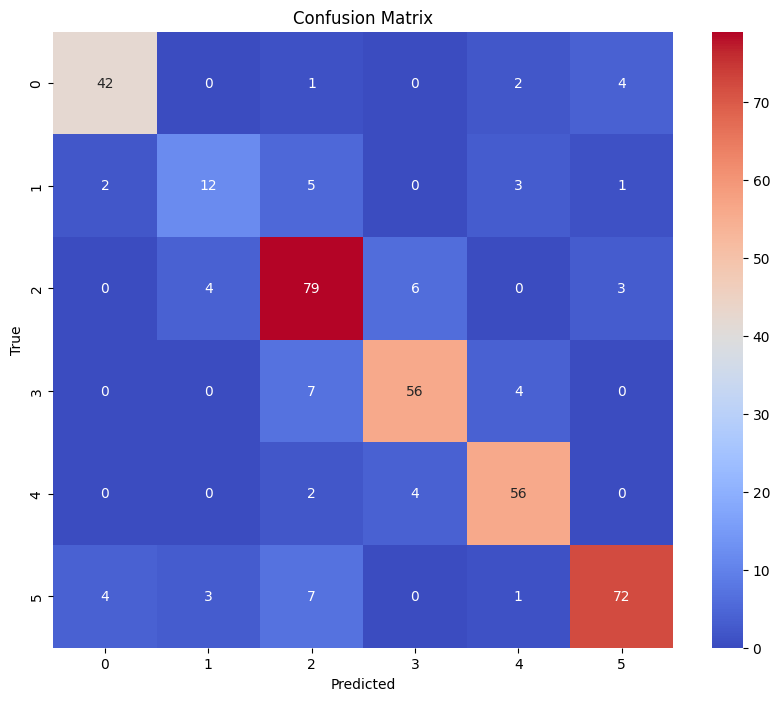

NameError: name 'precision_score' is not defined

In [52]:
def train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs):
    import wandb  # Import Wandb for tracking

    # Initialize Wandb logging
    wandb.init(project='WasteClassification', name='WasteClassifier_v1')

    for epoch in range(num_epochs):
        model.train()  # Set model to training mode

        # Training phase
        running_loss = 0.0
        for inputs, labels in train_loader:
            inputs, labels = inputs.cuda(), labels.cuda()  # Move inputs and labels to GPU

            optimizer.zero_grad()  # Zero out the gradients

            outputs = model(inputs)  # Forward pass
            loss = criterion(outputs, labels)  # Calculate loss

            loss.backward()  # Backpropagation
            optimizer.step()  # Update weights

            running_loss += loss.item() * inputs.size(0)  # Accumulate loss

        epoch_loss = running_loss / len(train_loader.dataset)  # Average loss per data point

        # Validation phase
        model.eval()  # Set model to evaluation mode
        val_loss = 0.0
        correct, total = 0, 0  # Initialize counters

        with torch.no_grad():  # Disable gradient calculation
            for inputs, labels in val_loader:
                inputs, labels = inputs.cuda(), labels.cuda()  # Move inputs and labels to GPU

                outputs = model(inputs)  # Forward pass
                loss = criterion(outputs, labels)  # Calculate loss

                val_loss += loss.item() * inputs.size(0)  # Accumulate loss

                _, predicted = torch.max(outputs.data, 1)  # Get predictions
                total += labels.size(0)  # Count total labels
                correct += (predicted == labels).sum().item()  # Count correct predictions

        val_loss = val_loss / len(val_loader.dataset)  # Average validation loss
        val_accuracy = correct / total  # Validation accuracy

        print(f'Epoch {epoch + 1}/{num_epochs}, Loss: {epoch_loss:.4f}, Val Loss: {val_loss:.4f}, Val Accuracy: {val_accuracy:.4f}')

        # Log metrics to Wandb
        wandb.log({
            'epoch_loss': epoch_loss,
            'val_loss': val_loss,
            'val_accuracy': val_accuracy
        })

        model.train()  # Return model to training mode

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()  # Loss function for multi-class classification
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)  # Adam optimizer with a learning rate of 0.001

# Train the model for 20 epochs
train_model(model, train_loader, val_loader, criterion, optimizer, 20)
# Evaluate the model on the test set
evaluate_model(model, test_loader)
